In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
import pickle
import os
import NN

import dataset_utils
import importlib
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import LinearLocator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv3D, MaxPooling3D, Embedding, LSTM, Bidirectional, Reshape, Concatenate

In [39]:
DATA_DIR = "sd_indvidual_3_class_data"
NUM_POINTS = 200
NUM_CLASSES = 3
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_utils.parse_dataset(NUM_POINTS, DATA_DIR)

processing class: jumping
processing class: speed_walking
processing class: walking


In [6]:
import os
import pickle

# Use the current directory as the base directory
base_dir = os.getcwd()
base_dir = os.path.join(base_dir, 'sd_indvidual_3_class_data')

# Create a mapping from class names to integers
class_mapping = {class_name: idx for idx, class_name in enumerate(sorted(os.listdir(base_dir)))}

# Initialize lists to store processed train and test data with labels
train_data = []
train_labels = []
test_data = []
test_labels = []

# Iterate over each class
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    
    # Ensure it's a directory
    if os.path.isdir(class_path):
        for split in ['train', 'test']:
            split_path = os.path.join(class_path, split)
            
            # Process files in the train/test folder
            for filename in os.listdir(split_path):
                file_path = os.path.join(split_path, filename)
                
                # Load the data (assuming it's a pickle file)
                with open(file_path, 'rb') as file:
                    data = pickle.load(file)
                
                # Limit to 100 slots if there are more than 100
                if len(data) > 100:
                    data = data[:100]
                
                if len(data) == 100:
                    label = class_mapping[class_name]
                    if split == 'train':
                        train_data.append(data)
                        train_labels.append(label)
                    elif split == 'test':
                        test_data.append(data)
                        test_labels.append(label)

# Now you have train_data, train_labels, test_data, and test_labels with integer labels

# Convert lists to NumPy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)


In [24]:
print(train_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [13]:
print(train_data)

[array([[ 8.48422128e-01,  3.72644086e-01, -1.34944216e-01,
        -1.25244141e-01,  1.70000000e+02],
       [ 2.20825670e+00,  7.08710240e-01,  5.43632411e-01,
         0.00000000e+00,  1.21000000e+02],
       [-1.75196328e+00, -1.70932672e+00, -1.81175753e+00,
        -1.25244141e-01,  1.56000000e+02],
       [ 2.02535497e+00,  4.54611441e-01,  6.67009980e-01,
         0.00000000e+00,  1.51000000e+02],
       [-1.18337748e+00,  6.84120034e-01, -6.76473600e-02,
        -1.25244141e-01,  2.19000000e+02],
       [ 1.78678751e+00, -1.35553513e-01, -7.96696629e-01,
         0.00000000e+00,  1.19000000e+02],
       [-1.31856571e+00,  1.10215354e+00,  6.50185766e-01,
        -1.25244141e-01,  2.23000000e+02],
       [-1.31856571e+00,  2.33299583e-01, -6.20392887e-02,
         0.00000000e+00,  1.76000000e+02],
       [ 1.43688855e+00,  1.34938758e-01,  3.32979233e-02,
         0.00000000e+00,  1.43000000e+02],
       [-1.31856571e+00,  4.47746675e-02, -2.07849143e-01,
         0.00000000e+0

In [25]:
print(train_data[0].shape)
print(test_data[0].shape)
print(train_labels.shape)
print(test_labels.shape)

(100, 5)
(100, 5)
(389,)
(96,)


In [26]:
print(train_points[0])

[ 5.435e-01 -2.783e+00  1.450e+02  0.000e+00  1.648e-02  1.267e-01
  1.760e+02 -9.092e-01 -1.812e+00  7.085e-01  1.880e+02  5.435e-01
 -3.757e-01 -1.252e-01  8.486e-01 -1.318e+00  8.575e-02  1.880e+02
  1.847e-01  5.435e-01  1.750e+02  1.570e+02  7.168e-01 -1.252e-01
 -9.092e-01 -3.406e-01 -3.643e-01  6.431e-01  1.580e+02  7.168e-01
  1.343e-01  4.546e-01  2.496e-01 -2.742e+00  0.000e+00 -8.472e-01
  1.437e+00  1.399e-01  1.252e-01  0.000e+00  6.758e-01  1.648e-02
  1.460e+02  1.252e-01 -1.252e-01  0.000e+00  1.252e-01  4.111e-01
 -6.274e-01  0.000e+00 -2.012e-01 -6.187e-01  1.612e+00  7.827e-01
 -6.187e-01  1.510e+02 -1.476e+00  1.450e+02  2.496e-01  5.464e-01
  0.000e+00  1.660e+02  2.070e+02 -4.224e-02  8.486e-01  0.000e+00
  2.025e+00  7.515e-01  1.120e+02 -1.875e+00  1.437e+00  1.804e-01
  1.847e-01  7.168e-01  1.730e+02  0.000e+00  1.460e+02  1.648e-02
  5.573e-02  4.629e-01  1.399e-01  1.120e+02 -3.201e+00  1.490e+02
  1.750e+02  1.700e+02  1.252e-01  7.085e-01  6.616e-01  1.730

In [14]:
from tensorflow import data as tf_data
import keras
#import PointNET

keras.utils.set_random_seed(seed=42)

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# Define the input shape (5 features)
sequence_length = 100  # Example: Fixed sequence length of 100 timesteps

input_shape = (sequence_length, 5)

# Define the model
model = models.Sequential()

# 1. CNN layers
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(BatchNormalization())
# model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))

# 2. Flatten the output before feeding into Dense layers
model.add(layers.Flatten())

# 3. Fully connected layer
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))


In [28]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 98, 64)            1024      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 49, 64)            0         
                                                                 
 batch_normalization_1 (Bat  (None, 49, 64)            256       
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# training
history = model.fit(train_data, train_labels, epochs=30, validation_data=(test_data, test_labels), verbose=1, callbacks=[early_stopping])

Epoch 1/30
13/13 [==============================] - 0s 12ms/step - loss: 0.0478 - accuracy: 0.9949 - val_loss: 2.2204 - val_accuracy: 0.4792
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 0.0425 - accuracy: 0.9974 - val_loss: 2.3625 - val_accuracy: 0.4688
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 0.0578 - accuracy: 0.9897 - val_loss: 2.3632 - val_accuracy: 0.4167
Epoch 4/30
13/13 [==============================] - 0s 8ms/step - loss: 0.0760 - accuracy: 0.9820 - val_loss: 2.1371 - val_accuracy: 0.4167
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 0.0835 - accuracy: 0.9820 - val_loss: 2.4019 - val_accuracy: 0.4167
Epoch 6/30
13/13 [==============================] - 0s 8ms/step - loss: 0.0903 - accuracy: 0.9820 - val_loss: 2.2457 - val_accuracy: 0.4479
Epoch 7/30
13/13 [==============================] - 0s 9ms/step - loss: 0.0692 - accuracy: 0.9743 - val_loss: 2.2671 - val_accuracy: 0.4271


In [37]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 2.2671 - accuracy: 0.4271


3/3 [==============================] - 0s 2ms/step


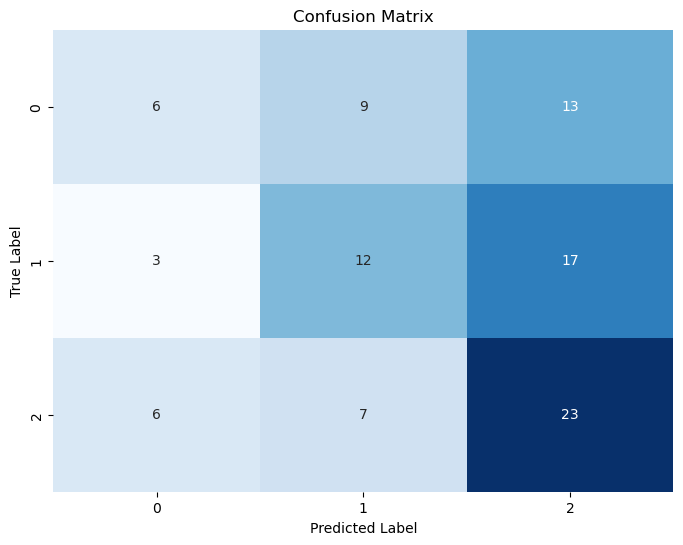

In [38]:
y_pred = np.argmax(model.predict(test_data), axis=1)

cm = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()